### Problem Statement
Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 

 

As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.

 

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

In [1754]:
%matplotlib inline

import numpy as np 
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen #Johansen Cointegration test

In [1755]:
#Importing the dataset
train = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')

In [1756]:
#train
train.head(15)

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0       1          5  2015-07-31   5263        555     1      1            0   
1       2          5  2015-07-31   6064        625     1      1            0   
2       3          5  2015-07-31   8314        821     1      1            0   
3       4          5  2015-07-31  13995       1498     1      1            0   
4       5          5  2015-07-31   4822        559     1      1            0   
5       6          5  2015-07-31   5651        589     1      1            0   
6       7          5  2015-07-31  15344       1414     1      1            0   
7       8          5  2015-07-31   8492        833     1      1            0   
8       9          5  2015-07-31   8565        687     1      1            0   
9      10          5  2015-07-31   7185        681     1      1            0   
10     11          5  2015-07-31  10457       1236     1      1            0   
11     12          5  2015-07-31   8959        962     1      1            0   
12     13          5  2015-07-31   8821        568     1      1            0   
13     14          5  2015-07-31   6544        710     1      1            0   
14     15          5  2015-07-31   9191        766     1      1            0   

    SchoolHoliday  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               1  
9               1  
10              1  
11              1  
12              0  
13              1  
14              1

In [1757]:
#store
store.head(15)

Store StoreType Assortment  CompetitionDistance  \
0       1         c          a               1270.0   
1       2         a          a                570.0   
2       3         a          a              14130.0   
3       4         c          c                620.0   
4       5         a          a              29910.0   
5       6         a          a                310.0   
6       7         a          c              24000.0   
7       8         a          a               7520.0   
8       9         a          c               2030.0   
9      10         a          a               3160.0   
10     11         a          c                960.0   
11     12         a          c               1070.0   
12     13         d          a                310.0   
13     14         a          a               1300.0   
14     15         d          c               4110.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
1                        11.0                    2007.0       1   
2                        12.0                    2006.0       1   
3                         9.0                    2009.0       0   
4                         4.0                    2015.0       0   
5                        12.0                    2013.0       0   
6                         4.0                    2013.0       0   
7                        10.0                    2014.0       0   
8                         8.0                    2000.0       0   
9                         9.0                    2009.0       0   
10                       11.0                    2011.0       1   
11                        NaN                       NaN       1   
12                        NaN                       NaN       1   
13                        3.0                    2014.0       1   
14                        3.0                    2010.0       1   

    Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0               NaN              NaN              NaN  
1              13.0           2010.0  Jan,Apr,Jul,Oct  
2              14.0           2011.0  Jan,Apr,Jul,Oct  
3               NaN              NaN              NaN  
4               NaN              NaN              NaN  
5               NaN              NaN              NaN  
6               NaN              NaN              NaN  
7               NaN              NaN              NaN  
8               NaN              NaN              NaN  
9               NaN              NaN              NaN  
10              1.0           2012.0  Jan,Apr,Jul,Oct  
11             13.0           2010.0  Jan,Apr,Jul,Oct  
12             45.0           2009.0  Feb,May,Aug,Nov  
13             40.0           2011.0  Jan,Apr,Jul,Oct  
14             14.0           2011.0  Jan,Apr,Jul,Oct

In [1758]:
#Analyzing Train Data
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [1759]:
#Analyzing Store Data
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [1760]:
##Filtering stores based on the given requirment

In [1761]:
store = store[store['Store'].isin([1,3,8,9,13,25,29,31,46])]

In [1762]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 0 to 45
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      9 non-null      int64  
 1   StoreType                  9 non-null      object 
 2   Assortment                 9 non-null      object 
 3   CompetitionDistance        9 non-null      float64
 4   CompetitionOpenSinceMonth  7 non-null      float64
 5   CompetitionOpenSinceYear   7 non-null      float64
 6   Promo2                     9 non-null      int64  
 7   Promo2SinceWeek            3 non-null      float64
 8   Promo2SinceYear            3 non-null      float64
 9   PromoInterval              3 non-null      object 
dtypes: float64(5), int64(2), object(3)
memory usage: 792.0+ bytes


In [1763]:
df = pd.DataFrame(train)
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [1764]:
# modify date format
df['Date'] = pd.to_datetime(df.Date)
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [1765]:
# sort date to bring oldest first
df= df.sort_values(by= ['Date','Store'])
df= df.reset_index(drop= True)
df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          2 2013-01-01      0          0     0      0            a   
1      2          2 2013-01-01      0          0     0      0            a   
2      3          2 2013-01-01      0          0     0      0            a   
3      4          2 2013-01-01      0          0     0      0            a   
4      5          2 2013-01-01      0          0     0      0            a   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [1766]:
# drop rows which has Sales zero.
df = df.loc[~(df['Sales']==0)]

# evaluate the number of rows left in each store
df.Store.value_counts().sort_index()

1       781
2       784
3       779
4       784
5       779
       ... 
1111    779
1112    779
1113    784
1114    784
1115    781
Name: Store, Length: 1115, dtype: int64

In [1767]:
# inspect any rows with Sales value as 0
df[df['Sales']==0]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

In [1768]:
store_df = []

    
for i in stores:
    store_df.append(df[df['Store'] == i])

for temp_df in store_df:
    temp_df['Date'] = pd.date_range(start = '2013-01-01', periods = len(temp_df), freq= 'D') # resequencing the date column, 
                                                                                             # as some date are missing due to dropping of rows
    temp_df.drop('Open',axis = 1,inplace = True) # now we have all stores open , there is only one value in Open column, so drop it.

for temp_df in store_df:
    print(temp_df.head(10))

       Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
1114       1          3 2013-01-01   5530        668      0            0   
2229       1          4 2013-01-02   4327        578      0            0   
3344       1          5 2013-01-03   4486        619      0            0   
4459       1          6 2013-01-04   4997        635      0            0   
6689       1          1 2013-01-05   7176        785      1            0   
7804       1          2 2013-01-06   5580        654      1            0   
8919       1          3 2013-01-07   5471        626      1            0   
10034      1          4 2013-01-08   4892        615      1            0   
11149      1          5 2013-01-09   4881        592      1            0   
12264      1          6 2013-01-10   4952        646      0            0   

       SchoolHoliday  
1114               1  
2229               1  
3344               1  
4459               1  
6689               1  
7804               1  
89

In [1769]:
#Saving Dataframe with Date as Index
store_new_df = []
for i in range(len(store_df)):
    store_df[i]['Date'] = pd.to_datetime(store_df[i]['Date'],format = "%Y-%m-%d")
    store_new_df.append(pd.DataFrame(store_df[i][['Date','Store','Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']]).set_index('Date'))

store_new_df[0].head()

Store  Sales  Customers  DayOfWeek  Promo  SchoolHoliday  \
Date                                                                   
2013-01-01      1   5530        668          3      0              1   
2013-01-02      1   4327        578          4      0              1   
2013-01-03      1   4486        619          5      0              1   
2013-01-04      1   4997        635          6      0              1   
2013-01-05      1   7176        785          1      1              1   

           StateHoliday  
Date                     
2013-01-01            0  
2013-01-02            0  
2013-01-03            0  
2013-01-04            0  
2013-01-05            0

In [1770]:
# merge two dataframe 
data_store = pd.merge(train,store, on = 'Store', how = 'inner')
data_store

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0         1          5 2015-07-31   5263        555     1      1            0   
1         1          4 2015-07-30   5020        546     1      1            0   
2         1          3 2015-07-29   4782        523     1      1            0   
3         1          2 2015-07-28   5011        560     1      1            0   
4         1          1 2015-07-27   6102        612     1      1            0   
...     ...        ...        ...    ...        ...   ...    ...          ...   
8105     46          6 2013-01-05   4848        651     1      0            0   
8106     46          5 2013-01-04   4125        569     1      0            0   
8107     46          4 2013-01-03   4177        553     1      0            0   
8108     46          3 2013-01-02   4016        582     1      0            0   
8109     46          2 2013-01-01      0          0     0      0            a   

      SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                 1         c          a               1270.0   
1                 1         c          a               1270.0   
2                 1         c          a               1270.0   
3                 1         c          a               1270.0   
4                 1         c          a               1270.0   
...             ...       ...        ...                  ...   
8105              0         c          a               1200.0   
8106              1         c          a               1200.0   
8107              1         c          a               1200.0   
8108              1         c          a               1200.0   
8109              1         c          a               1200.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                           9.0                    2008.0       0   
2                           9.0                    2008.0       0   
3                           9.0                    2008.0       0   
4                           9.0                    2008.0       0   
...                         ...                       ...     ...   
8105                        9.0                    2005.0       1   
8106                        9.0                    2005.0       1   
8107                        9.0                    2005.0       1   
8108                        9.0                    2005.0       1   
8109                        9.0                    2005.0       1   

      Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0                 NaN              NaN              NaN  
1                 NaN              NaN              NaN  
2                 NaN              NaN              NaN  
3                 NaN              NaN              NaN  
4                 NaN              NaN              NaN  
...               ...              ...              ...  
8105             14.0           2011.0  Jan,Apr,Jul,Oct  
8106             14.0           2011.0  Jan,Apr,Jul,Oct  
8107             14.0           2011.0  Jan,Apr,Jul,Oct  
8108             14.0           2011.0  Jan,Apr,Jul,Oct  
8109             14.0           2011.0  Jan,Apr,Jul,Oct  

[8110 rows x 18 columns]

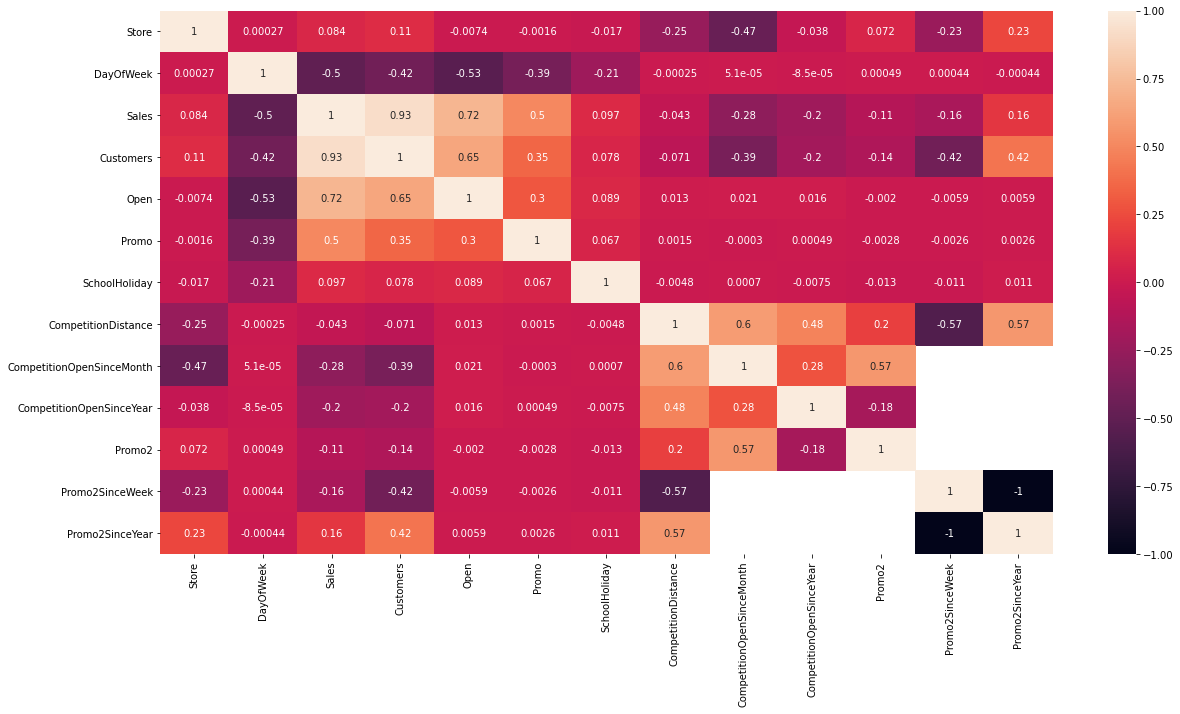

In [1771]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(data_store.corr(), annot = True);

### We can see a strong positive correlation between the amount of Sales and Customers visiting the store. We can also observe a positive correlation between a running promotion (Promo = 1) and number of customers.# Sales trend over days



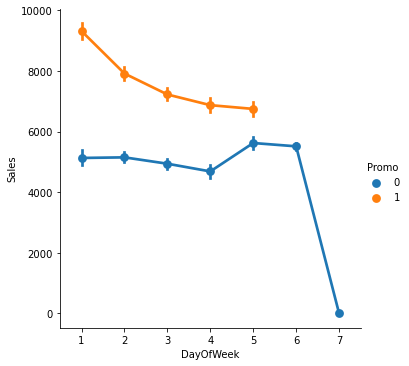

In [1772]:
# Sales trend over days
sns.factorplot(data = data_store, x = "DayOfWeek", y = "Sales", hue = "Promo");

#### We can see from the trend that there are no promotions on the weekends i.e Saturday and Sunday, which makes sense as stores want to earn a maximum profit during the time when people do their house chores. The sales tend to increase on Sunday because people shop during the weekend. We can also see that the maximum sale happens on Mondays when there are promotional offers.

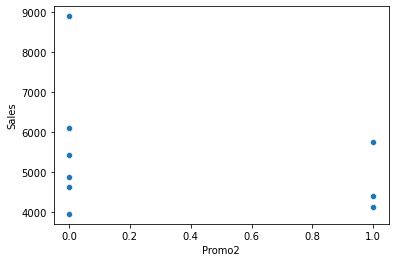

In [1773]:
# Analysing the Sales and Promo2 for different stores
grouped_df_promo2 = data_store.groupby('Store')[['Sales','Promo2']].mean()
sns.scatterplot(grouped_df_promo2['Promo2'],grouped_df_promo2['Sales'])
plt.show()

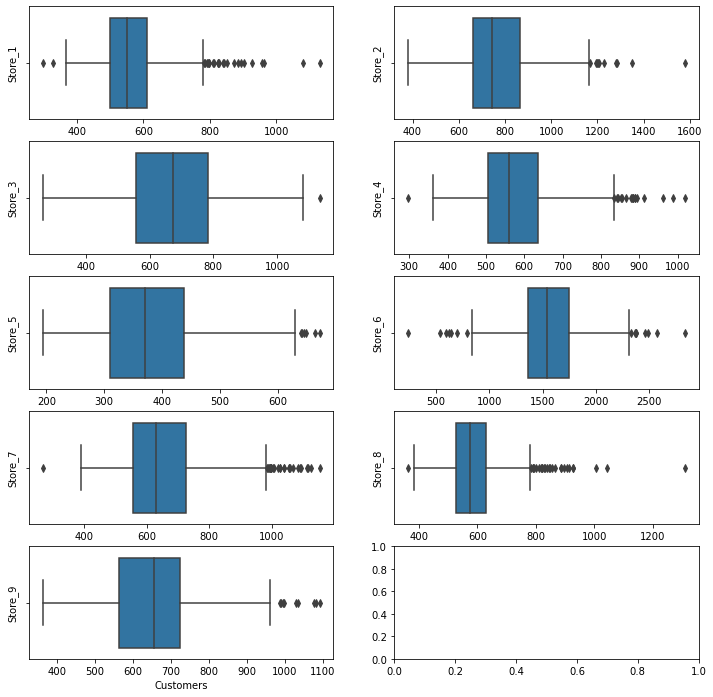

In [1774]:
# Spread of Sales of all store
fig, axs = plt.subplots(figsize=(12, 12),nrows=5,ncols=2)
for i in range(9):
  axs[np.floor(i/2).astype('int')][i%2].set_ylabel("Store_"+str(i+1))
  sns.boxplot(x=store_new_df[i]['Customers'],whis=1.5, ax= axs[np.floor(i/2).astype('int')][i%2] )
plt.show()

In [1775]:
#capping to 0.99th percentile
for i in range(9):
      store_new_df[i].loc[store_new_df[i]['Sales'] > store_new_df[i]['Sales'].quantile(0.99),'Sales']= store_new_df[i]['Sales'].quantile(0.99)

## Model Building for Store 1

In [1776]:
##Data Preparation

In [1777]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[0])

781

In [1778]:
train = store_new_df[0][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[0][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

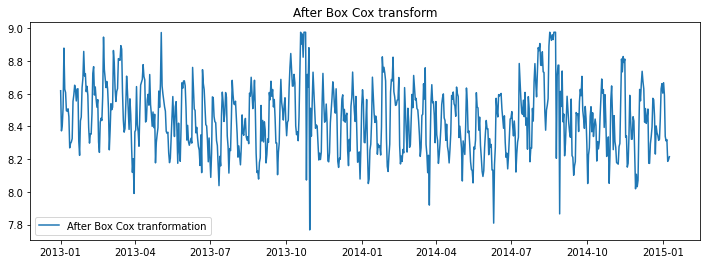

In [1779]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1780]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -5.322766
p-value: 0.000005
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -4.238660
p-value: 0.000566
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -8.471002
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.355630
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.850025
p-value: 0.000000
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


#### Training data is stationary

## Model Building

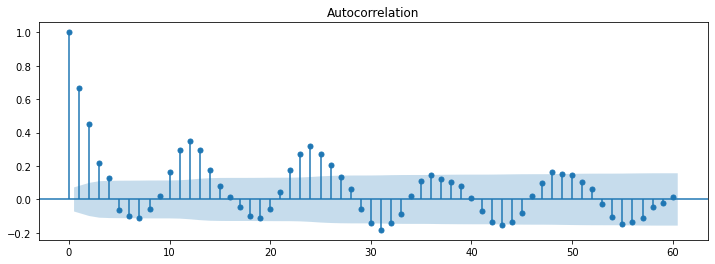

In [1781]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

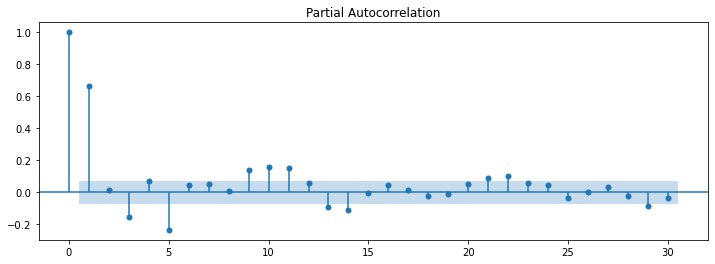

In [1782]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1783]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  739
Model:                     ARMA(1, 1)   Log Likelihood                 341.238
Method:                       css-mle   S.D. of innovations              0.152
Date:                Mon, 16 Aug 2021   AIC                           -674.476
Time:                        22:23:42   BIC                           -656.055
Sample:                    01-01-2013   HQIC                          -667.373
                         - 01-09-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.4493      0.017    499.927      0.000       8.416       8.482
ar.L1.Sales     0.6744      0.037     18.202      0.000       0.602       0.747
ma.L1.Sales    -0.0158      0.046     -0.345    

In [1784]:
y_hat_ar = store_new_df[0]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


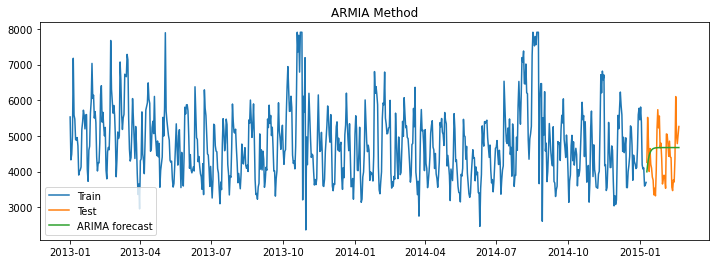

In [1785]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[0]['Sales'][:-42], label='Train')
plt.plot(store_new_df[0]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1786]:
results = pd.DataFrame({'Method':[], 'MAPE': [], 'RMSE': []})

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_1_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE    RMSE
0  Store_1_ARIMA   15.48  756.47

### VAR

In [1787]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  739
Model:                             VAR(1)   Log Likelihood                1400.071
Date:                    Mon, 16 Aug 2021   AIC                          -2786.142
Time:                            22:23:43   BIC                          -2753.905
Sample:                        01-01-2013   HQIC                         -2773.712
                             - 01-09-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            24.68, 3.75   Jarque-Bera (JB):       1403.15, 73.67
Prob(Q):                        0.00, 0.05   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.36, 1.17   Skew:                      -0.46, 0.07
Prob(H) (two-sided):            0.02, 0.21   Kurtosis:                   9.69, 4.54


In [1788]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

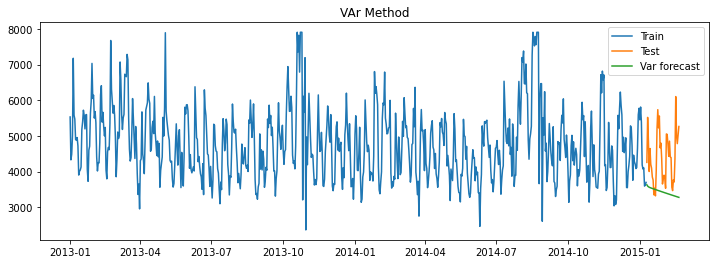

In [1789]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[0]['Sales'][:-42], label='Train')
plt.plot(store_new_df[0]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1790]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_1_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0  Store_1_ARIMA   15.48   756.47
0     Store_1_VAR  20.94  1227.40

### Johansen cointegration Test

In [1791]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1792]:
### No Conintegration hence both sales and Customers are stationary

In [1793]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(1,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  739
Model:                            VARX(1)   Log Likelihood                1472.438
                              + intercept   AIC                          -2922.875
Date:                    Mon, 16 Aug 2021   BIC                          -2872.217
Time:                            22:23:45   HQIC                         -2903.342
Sample:                        01-01-2013                                         
                             - 01-09-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.10, 3.29   Jarque-Bera (JB):        533.93, 94.44
Prob(Q):                        0.76, 0.07   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.35, 1.19   Skew:                      -0.41, 0.15
P

In [1794]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


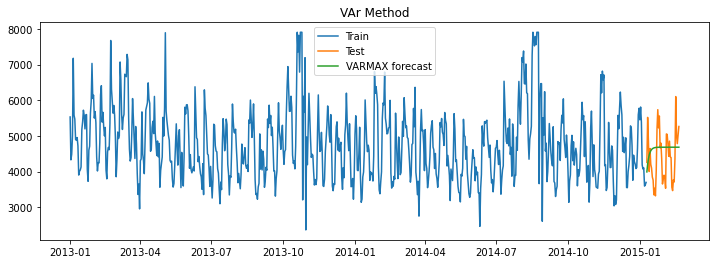

In [1795]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[0]['Sales'][:-42], label='Train')
plt.plot(store_new_df[0]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1796]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_1_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01

In [1797]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(1,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  739
Model:                            VARX(1)   Log Likelihood                1582.350
                              + intercept   AIC                          -3142.701
Date:                    Mon, 16 Aug 2021   BIC                          -3092.042
Time:                            22:23:48   HQIC                         -3123.167
Sample:                        01-01-2013                                         
                             - 01-09-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             1.21, 1.83   Jarque-Bera (JB):        370.31, 53.18
Prob(Q):                        0.27, 0.18   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.62, 1.15   Skew:                     -0.19, -0.04
P

In [1798]:
## Better AIC value with promo

In [1799]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



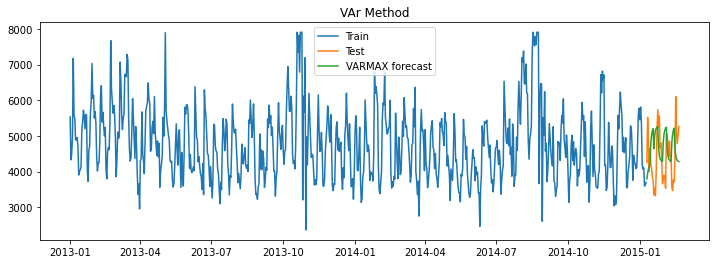

In [1800]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[0]['Sales'][:-42], label='Train')
plt.plot(store_new_df[0]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1801]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_1_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31

<AxesSubplot:>

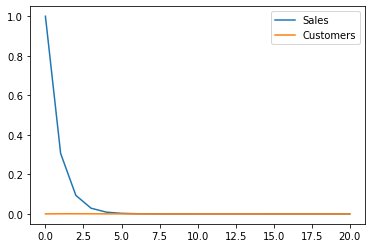

In [1802]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

### ------------------------------------------------------------------------------------------------

## Model Building for store 3

In [1803]:
##Data Preparation

In [1804]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[1])

779

In [1805]:
train = store_new_df[1][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[1][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

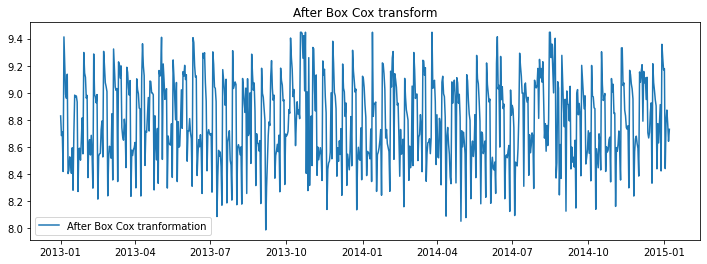

In [1806]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1807]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -6.382334
p-value: 0.000000
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -5.651252
p-value: 0.000001
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -8.092541
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.319335
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.356925
p-value: 0.000004
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


#### Training data is stationary

## Model Building

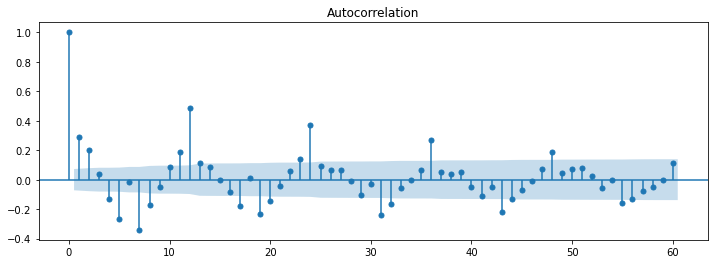

In [1808]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

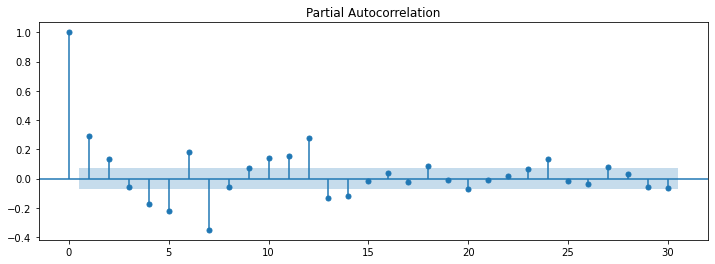

In [1809]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1810]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(11, 0, 7))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  737
Model:                    ARMA(11, 7)   Log Likelihood                  -2.571
Method:                       css-mle   S.D. of innovations              0.242
Date:                Mon, 16 Aug 2021   AIC                             45.142
Time:                        22:24:28   BIC                            137.194
Sample:                    01-01-2013   HQIC                            80.640
                         - 01-07-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.7940      0.013    654.446      0.000       8.768       8.820
ar.L1.Sales      0.8350      0.192      4.359      0.000       0.460       1.210
ar.L2.Sales     -0.3014      0.152     -1.98

In [1811]:
y_hat_ar = store_new_df[1]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


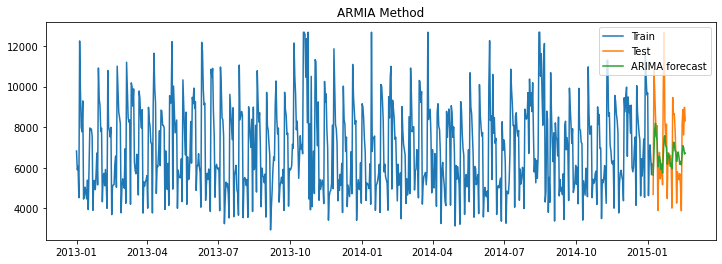

In [1812]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[1]['Sales'][:-42], label='Train')
plt.plot(store_new_df[1]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1813]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_3_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18

### VAR

In [1814]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                             VAR(1)   Log Likelihood                 651.052
Date:                    Mon, 16 Aug 2021   AIC                          -1288.104
Time:                            22:24:36   BIC                          -1255.885
Sample:                        01-01-2013   HQIC                         -1275.679
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            88.69, 2.57   Jarque-Bera (JB):          14.79, 4.42
Prob(Q):                        0.00, 0.11   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         0.87, 1.10   Skew:                      0.17, -0.02
Prob(H) (two-sided):            0.28, 0.44   Kurtosis:                   3.61, 3.38


In [1815]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

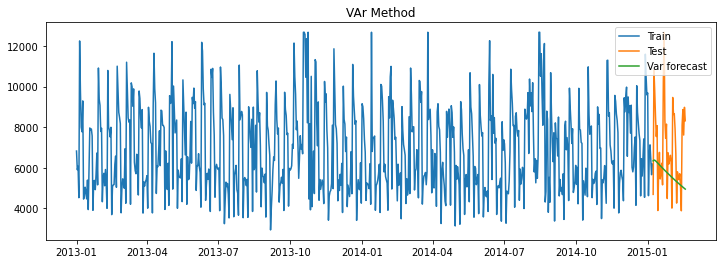

In [1816]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[1]['Sales'][:-42], label='Train')
plt.plot(store_new_df[1]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1817]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_3_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26

### Johansen cointegration Test

In [1818]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1819]:
### No Conintegration hence both sales and Customers are stationary

In [1820]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(1,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                            VARX(1)   Log Likelihood                 873.583
                              + intercept   AIC                          -1725.166
Date:                    Mon, 16 Aug 2021   BIC                          -1674.537
Time:                            22:24:41   HQIC                         -1705.641
Sample:                        01-01-2013                                         
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.13, 2.99   Jarque-Bera (JB):          21.15, 9.48
Prob(Q):                        0.72, 0.08   Prob(JB):                   0.00, 0.01
Heteroskedasticity (H):         0.89, 1.14   Skew:                     -0.34, -0.17
P

In [1821]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


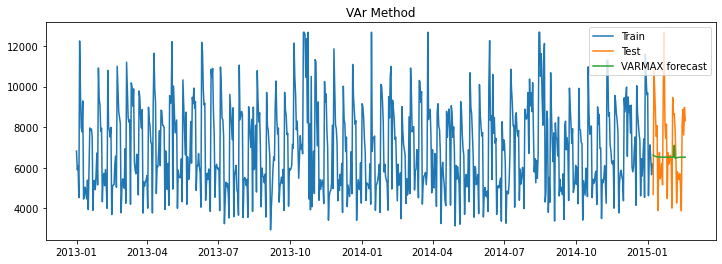

In [1822]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[1]['Sales'][:-42], label='Train')
plt.plot(store_new_df[1]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1823]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_3_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11

In [1824]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(1,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                            VARX(1)   Log Likelihood                1182.599
                              + intercept   AIC                          -2343.197
Date:                    Mon, 16 Aug 2021   BIC                          -2292.569
Time:                            22:25:06   HQIC                         -2323.673
Sample:                        01-01-2013                                         
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            74.73, 3.55   Jarque-Bera (JB):         91.62, 16.70
Prob(Q):                        0.00, 0.06   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.33, 1.21   Skew:                      0.32, -0.35
P

In [1825]:
## Better AIC value with promo

In [1826]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



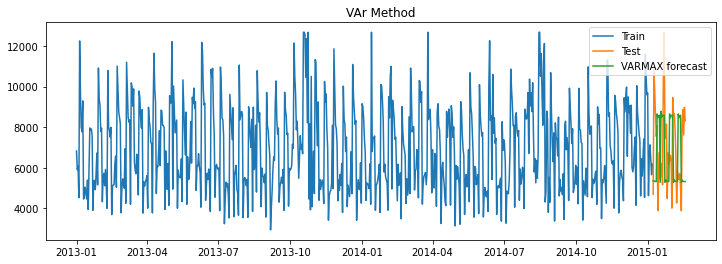

In [1827]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[1]['Sales'][:-42], label='Train')
plt.plot(store_new_df[1]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1828]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_3_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17

<AxesSubplot:>

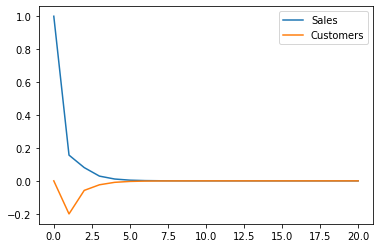

In [1829]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

## ____________________________________________________________________________________________________________________

#### Model Building for store 8

In [1830]:
##Data Preparation

In [1831]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[2])

784

In [1832]:
train = store_new_df[2][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[2][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

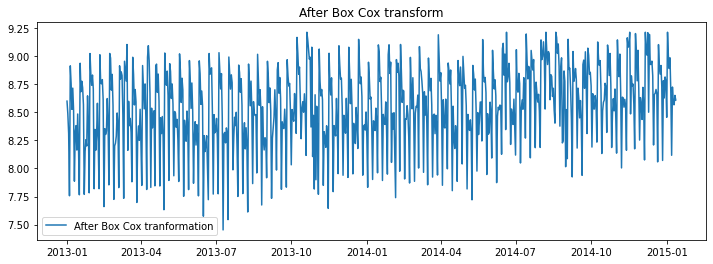

In [1833]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1834]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -3.178387
p-value: 0.021270
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -2.915281
p-value: 0.043600
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -7.126625
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.469992
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.813130
p-value: 0.000000
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


#### Training data is stationary

## Model Building

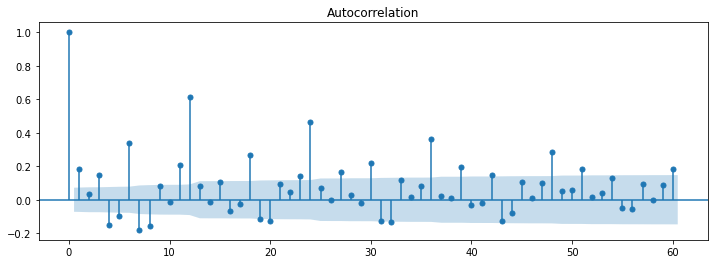

In [1835]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

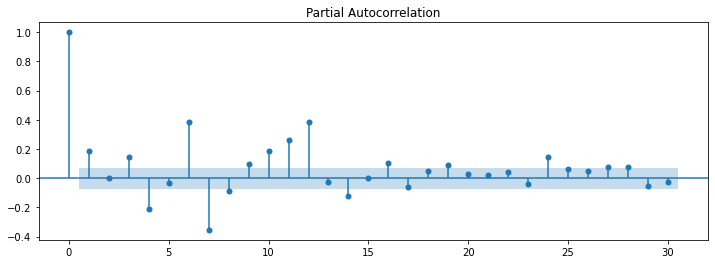

In [1836]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1837]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(11, 0, 7))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  742
Model:                    ARMA(11, 7)   Log Likelihood                 -49.081
Method:                       css-mle   S.D. of innovations              0.257
Date:                Mon, 16 Aug 2021   AIC                            138.163
Time:                        22:25:23   BIC                            230.350
Sample:                    01-01-2013   HQIC                           173.702
                         - 01-12-2015                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            8.5502      0.055    155.597      0.000       8.443       8.658
ar.L1.Sales      0.6724      0.103      6.544      0.000       0.471       0.874
ar.L2.Sales     -0.1782      0.139     -1.28

In [1838]:
y_hat_ar = store_new_df[2]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


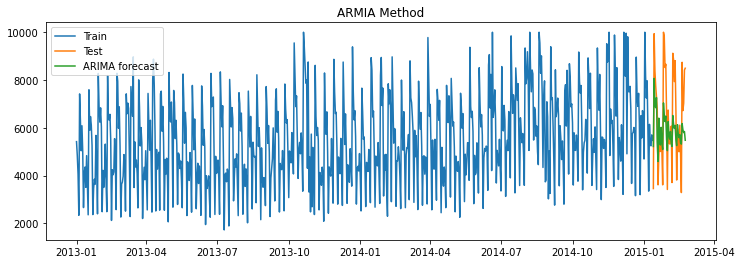

In [1839]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[2]['Sales'][:-42], label='Train')
plt.plot(store_new_df[2]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1840]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_8_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73

### VAR

In [1841]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(2,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                             VAR(2)   Log Likelihood                 503.452
Date:                    Mon, 16 Aug 2021   AIC                           -984.905
Time:                            22:25:29   BIC                           -934.202
Sample:                        01-01-2013   HQIC                          -965.358
                             - 01-12-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.72, 0.13   Jarque-Bera (JB):           3.70, 1.87
Prob(Q):                        0.40, 0.72   Prob(JB):                   0.16, 0.39
Heteroskedasticity (H):         0.64, 0.79   Skew:                       0.01, 0.08
Prob(H) (two-sided):            0.00, 0.07   Kurtosis:                   3.35, 2.81


In [1842]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

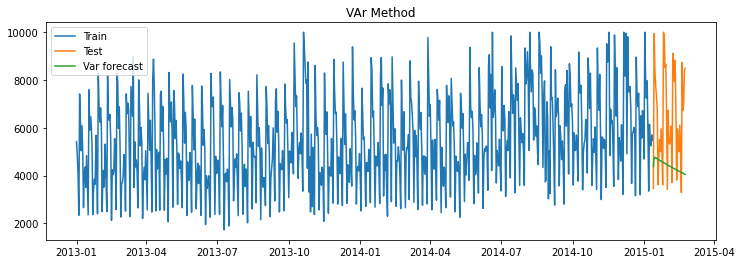

In [1843]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[2]['Sales'][:-42], label='Train')
plt.plot(store_new_df[2]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1844]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_8_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01

### Johansen cointegration Test

In [1845]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1846]:
### No Conintegration hence both sales and Customers are stationary

In [1847]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                            VARX(2)   Log Likelihood                 687.332
                              + intercept   AIC                          -1344.665
Date:                    Mon, 16 Aug 2021   BIC                          -1275.524
Time:                            22:25:37   HQIC                         -1318.010
Sample:                        01-01-2013                                         
                             - 01-12-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             7.21, 0.19   Jarque-Bera (JB):          31.78, 1.33
Prob(Q):                        0.01, 0.66   Prob(JB):                   0.00, 0.51
Heteroskedasticity (H):         0.77, 0.79   Skew:                      -0.50, 0.05
P

In [1848]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


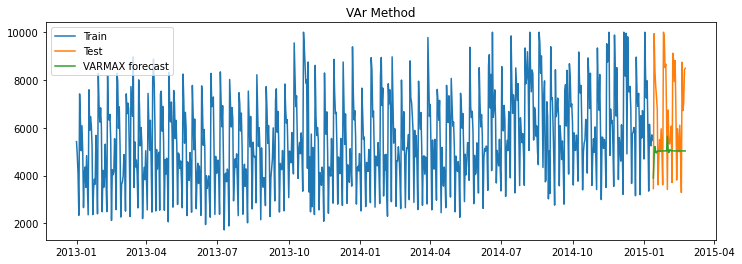

In [1849]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[2]['Sales'][:-42], label='Train')
plt.plot(store_new_df[2]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1850]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_8_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17

In [1851]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                            VARX(2)   Log Likelihood                 806.378
                              + intercept   AIC                          -1582.756
Date:                    Mon, 16 Aug 2021   BIC                          -1513.615
Time:                            22:26:01   HQIC                         -1556.101
Sample:                        01-01-2013                                         
                             - 01-12-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             4.67, 0.00   Jarque-Bera (JB):          20.72, 0.17
Prob(Q):                        0.03, 0.95   Prob(JB):                   0.00, 0.92
Heteroskedasticity (H):         0.73, 0.85   Skew:                      -0.36, 0.01
P

In [1852]:
## Better AIC value with promo

In [1853]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



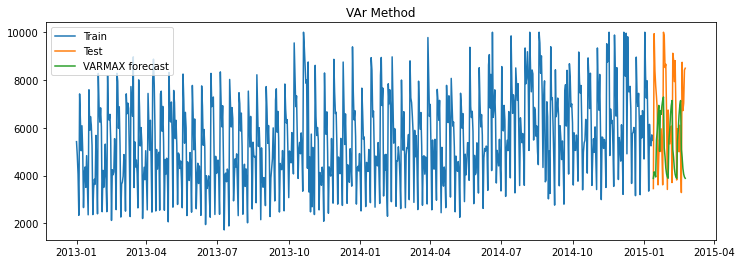

In [1854]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[2]['Sales'][:-42], label='Train')
plt.plot(store_new_df[2]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1855]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_8_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56

<AxesSubplot:>

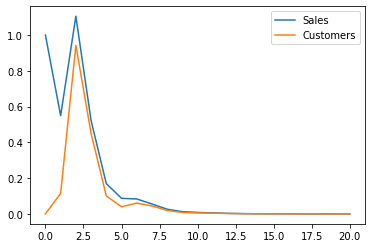

In [1856]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

## ____________________________________________________________________________________________________________________

#### Model Building for store 9

In [1857]:
##Data Preparation

In [1858]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[3])

779

In [1859]:
train = store_new_df[3][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[3][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

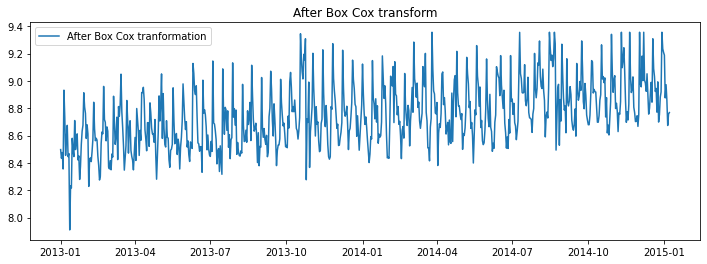

In [1860]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1861]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -2.578744
p-value: 0.097471
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -3.159024
p-value: 0.022482
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -8.092541
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.319335
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.356925
p-value: 0.000004
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


#### Training data is stationary

## Model Building

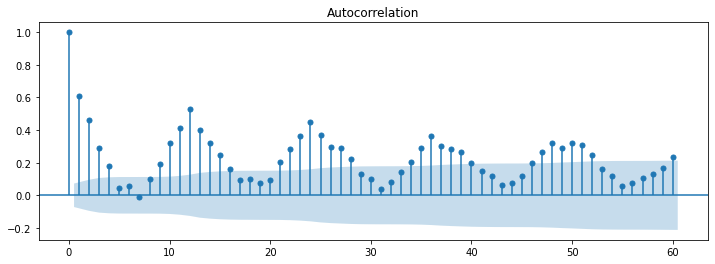

In [1862]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

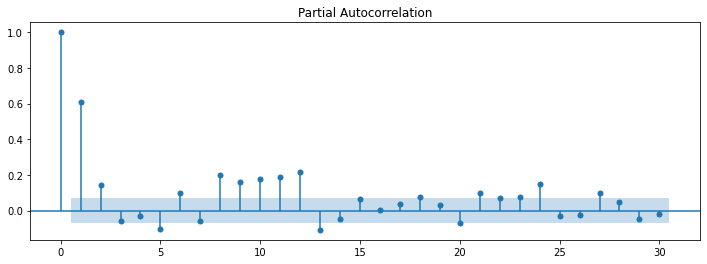

In [1863]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1864]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  737
Model:                     ARMA(1, 1)   Log Likelihood                 208.354
Method:                       css-mle   S.D. of innovations              0.182
Date:                Mon, 16 Aug 2021   AIC                           -408.708
Time:                        22:26:03   BIC                           -390.298
Sample:                    01-01-2013   HQIC                          -401.608
                         - 01-07-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.7519      0.020    439.880      0.000       8.713       8.791
ar.L1.Sales     0.7247      0.037     19.390      0.000       0.651       0.798
ma.L1.Sales    -0.1818      0.050     -3.623    

In [1865]:
y_hat_ar = store_new_df[3]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


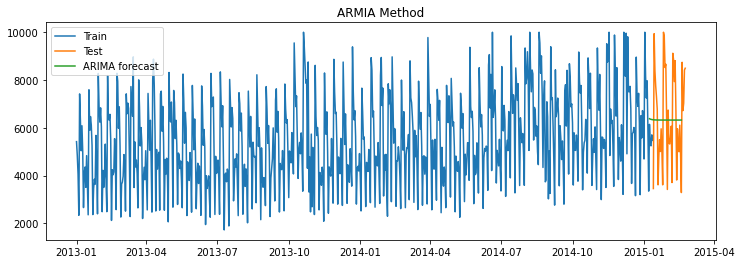

In [1866]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[2]['Sales'][:-42], label='Train')
plt.plot(store_new_df[2]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1867]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_9_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56
0                Store_9_ARIMA   17.06  1985.39

### VAR

In [1868]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                             VAR(1)   Log Likelihood                1386.776
Date:                    Mon, 16 Aug 2021   AIC                          -2759.552
Time:                            22:26:04   BIC                          -2727.334
Sample:                        01-01-2013   HQIC                         -2747.128
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            64.61, 0.48   Jarque-Bera (JB):          98.84, 7.24
Prob(Q):                        0.00, 0.49   Prob(JB):                   0.00, 0.03
Heteroskedasticity (H):         0.96, 1.07   Skew:                       0.50, 0.09
Prob(H) (two-sided):            0.72, 0.62   Kurtosis:                   4.49, 3.45


In [1869]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

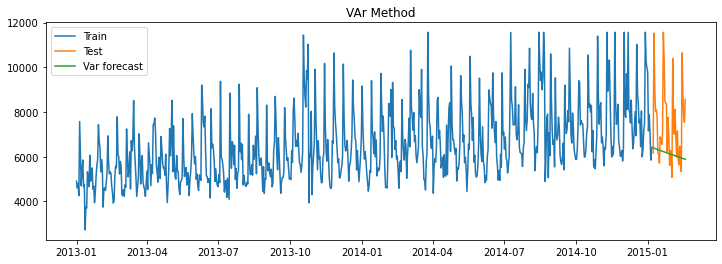

In [1870]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[3]['Sales'][:-42], label='Train')
plt.plot(store_new_df[3]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1871]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_9_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56
0                Store_9_ARIMA   17.06  1985.39
0                   Store_9_VAR  17.64  2087.96

### Johansen cointegration Test

In [1872]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1873]:
### No Conintegration hence both sales and Customers are stationary

In [1874]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                            VARX(2)   Log Likelihood                1502.029
                              + intercept   AIC                          -2974.058
Date:                    Mon, 16 Aug 2021   BIC                          -2905.019
Time:                            22:26:17   HQIC                         -2947.434
Sample:                        01-01-2013                                         
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.00, 0.30   Jarque-Bera (JB):         168.28, 3.55
Prob(Q):                        0.99, 0.58   Prob(JB):                   0.00, 0.17
Heteroskedasticity (H):         1.01, 1.07   Skew:                       0.80, 0.04
P

In [1875]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


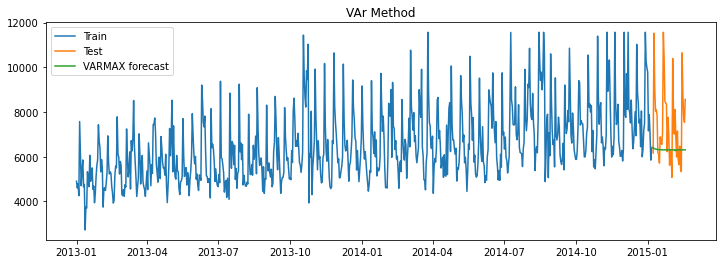

In [1876]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[3]['Sales'][:-42], label='Train')
plt.plot(store_new_df[3]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1877]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_9_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56
0                Store_9_ARIMA   17.06  1985.39
0                   Store_9_VAR  17.64  2087.96
0  Store_9_VARMAX_SchoolHoliday  17.10  1991.61

In [1878]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                            VARX(2)   Log Likelihood                1531.338
                              + intercept   AIC                          -3032.676
Date:                    Mon, 16 Aug 2021   BIC                          -2963.637
Time:                            22:26:22   HQIC                         -3006.052
Sample:                        01-01-2013                                         
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             6.29, 0.76   Jarque-Bera (JB):         102.26, 7.44
Prob(Q):                        0.01, 0.38   Prob(JB):                   0.00, 0.02
Heteroskedasticity (H):         0.99, 1.00   Skew:                      0.60, -0.11
P

In [1879]:
## Better AIC value with promo

In [1880]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



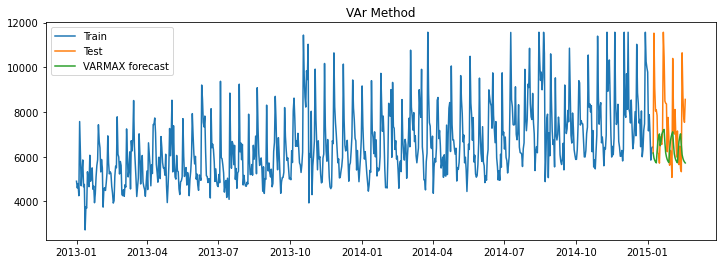

In [1881]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[3]['Sales'][:-42], label='Train')
plt.plot(store_new_df[3]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1882]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_9_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56
0                Store_9_ARIMA   17.06  1985.39
0                   Store_9_VAR  17.64  2087.96
0  Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                 Store_9_Promo  20.15  2082.44

<AxesSubplot:>

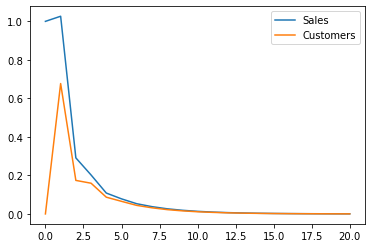

In [1883]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

## ____________________________________________________________________________________________________________________

## ____________________________________________________________________________________________________________________

#### Model Building for store 13

In [1884]:
##Data Preparation

In [1885]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[4])

621

In [1886]:
train = store_new_df[4][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[4][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

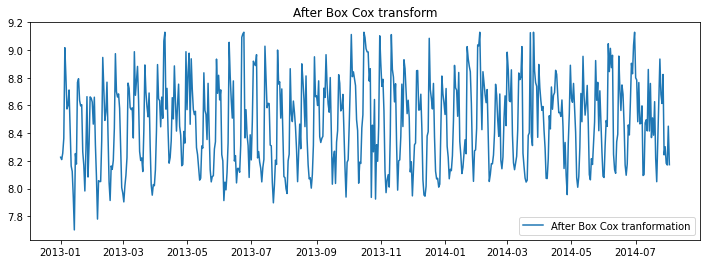

In [1887]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1888]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -6.166842
p-value: 0.000000
Critical Values:
	5%: -2.867


Customers: ADF test results:
ADF Statistic: -5.519847
p-value: 0.000002
Critical Values:
	5%: -2.867


DayOfWeek: ADF test results:
ADF Statistic: -7.103760
p-value: 0.000000
Critical Values:
	5%: -2.867


Promo: ADF test results:
ADF Statistic: -6.355938
p-value: 0.000000
Critical Values:
	5%: -2.867


SchoolHoliday: ADF test results:
ADF Statistic: -6.560545
p-value: 0.000000
Critical Values:
	5%: -2.867


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.867


#### Training data is stationary

## Model Building

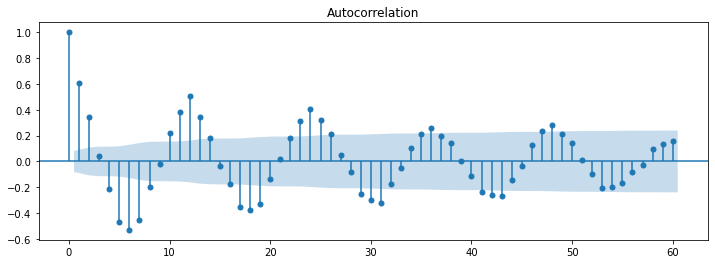

In [1889]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

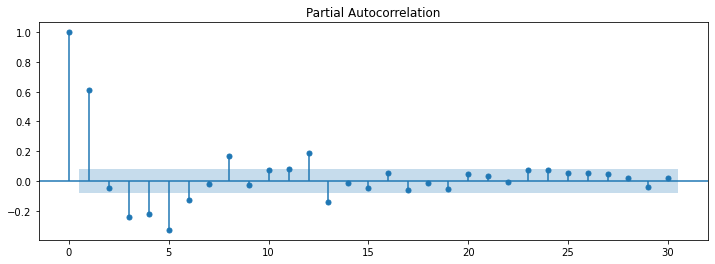

In [1890]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1891]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  579
Model:                     ARMA(1, 1)   Log Likelihood                  -6.669
Method:                       css-mle   S.D. of innovations              0.245
Date:                Mon, 16 Aug 2021   AIC                             21.338
Time:                        22:26:23   BIC                             38.783
Sample:                    01-01-2013   HQIC                            28.140
                         - 08-02-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.4688      0.025    334.750      0.000       8.419       8.518
ar.L1.Sales     0.5822      0.048     12.201      0.000       0.489       0.676
ma.L1.Sales     0.0420      0.052      0.802    

In [1892]:
y_hat_ar = store_new_df[4]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


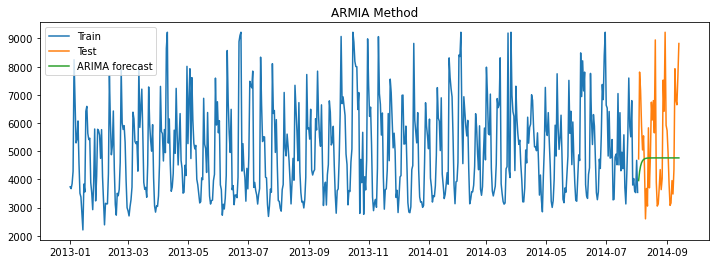

In [1893]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[4]['Sales'][:-42], label='Train')
plt.plot(store_new_df[4]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1894]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_13_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56
0                Store_9_ARIMA   17.06  1985.39
0                   Store_9_VAR  17.64  2087.96
0  Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                 Store_9_Promo  20.15  2082.44
0               Store_13_ARIMA   29.89  1921.82

### VAR

In [1895]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  579
Model:                             VAR(1)   Log Likelihood                 755.093
Date:                    Mon, 16 Aug 2021   AIC                          -1496.187
Time:                            22:26:24   BIC                          -1465.658
Sample:                        01-01-2013   HQIC                         -1484.283
                             - 08-02-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            15.47, 0.51   Jarque-Bera (JB):         19.35, 26.87
Prob(Q):                        0.00, 0.47   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.97, 1.45   Skew:                      0.35, -0.35
Prob(H) (two-sided):            0.83, 0.01   Kurtosis:                   3.56, 3.80


In [1896]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

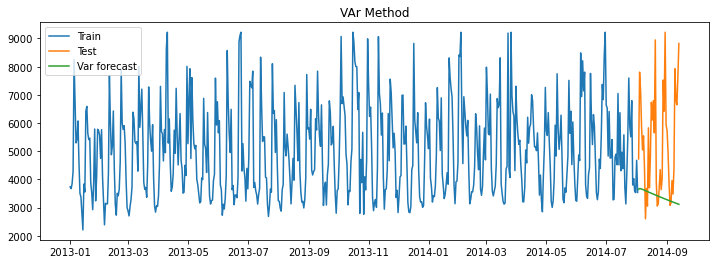

In [1897]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[4]['Sales'][:-42], label='Train')
plt.plot(store_new_df[4]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1898]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_13_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                Store_1_ARIMA   15.48   756.47
0                   Store_1_VAR  20.94  1227.40
0  Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                 Store_1_Promo  20.04   982.31
0                Store_3_ARIMA   18.22  1674.18
0                   Store_3_VAR  24.86  2402.26
0  Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                 Store_3_Promo  37.30  2773.17
0                Store_8_ARIMA   21.08  1634.73
0                   Store_8_VAR  32.55  2861.01
0  Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                 Store_8_Promo  37.01  2903.56
0                Store_9_ARIMA   17.06  1985.39
0                   Store_9_VAR  17.64  2087.96
0  Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                 Store_9_Promo  20.15  2082.44
0               Store_13_ARIMA   29.89  1921.82
0                  Store_13_VAR  32.24  2657.13

### Johansen cointegration Test

In [1899]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1900]:
### No Conintegration hence both sales and Customers are stationary

In [1901]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  579
Model:                            VARX(2)   Log Likelihood                 827.615
                              + intercept   AIC                          -1625.230
Date:                    Mon, 16 Aug 2021   BIC                          -1559.810
Time:                            22:26:29   HQIC                         -1599.723
Sample:                        01-01-2013                                         
                             - 08-02-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.20, 0.05   Jarque-Bera (JB):         38.41, 26.58
Prob(Q):                        0.65, 0.82   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.92, 1.43   Skew:                      0.59, -0.35
P

In [1902]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


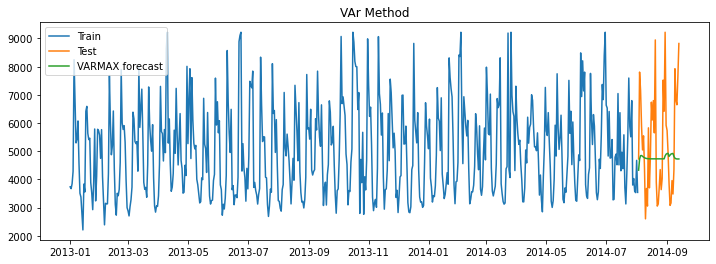

In [1903]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[4]['Sales'][:-42], label='Train')
plt.plot(store_new_df[4]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1904]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_13_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80

In [1905]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  579
Model:                            VARX(2)   Log Likelihood                1013.330
                              + intercept   AIC                          -1996.660
Date:                    Mon, 16 Aug 2021   BIC                          -1931.241
Time:                            22:26:36   HQIC                         -1971.153
Sample:                        01-01-2013                                         
                             - 08-02-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             4.42, 0.00   Jarque-Bera (JB):         17.25, 54.32
Prob(Q):                        0.04, 0.99   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.09, 1.57   Skew:                      0.42, -0.44
P

In [1906]:
## Better AIC value with promo

In [1907]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



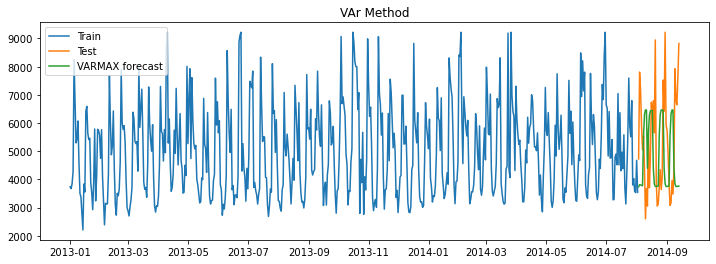

In [1908]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[4]['Sales'][:-42], label='Train')
plt.plot(store_new_df[4]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1909]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_13_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78

<AxesSubplot:>

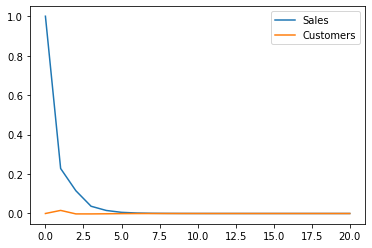

In [1910]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

#### Model Building for store 25

In [1911]:
##Data Preparation

In [1912]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[5])

750

In [1913]:
train = store_new_df[5][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[5][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

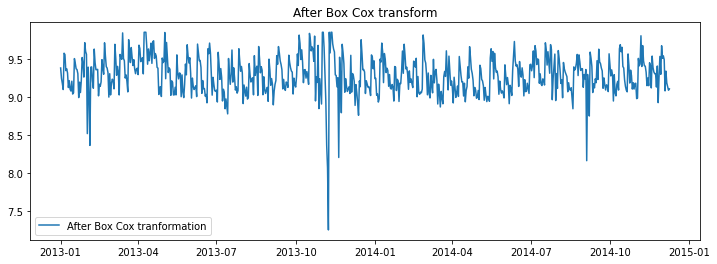

In [1914]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1915]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -5.104218
p-value: 0.000014
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -4.367270
p-value: 0.000339
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -14.377765
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.527307
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.296374
p-value: 0.000006
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.866


#### Training data is stationary

## Model Building

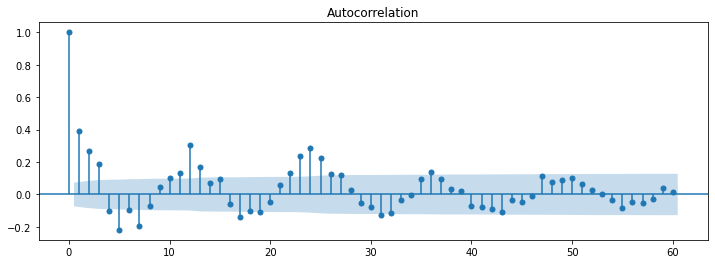

In [1916]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

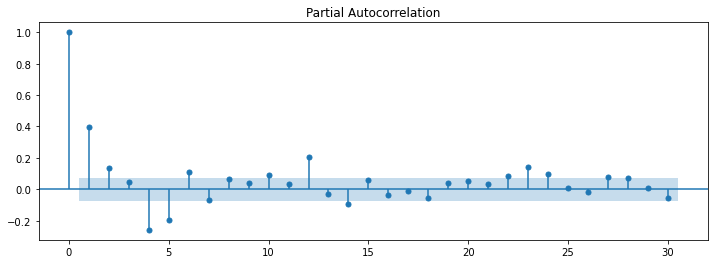

In [1917]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1918]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  708
Model:                     ARMA(1, 1)   Log Likelihood                  28.243
Method:                       css-mle   S.D. of innovations              0.232
Date:                Mon, 16 Aug 2021   AIC                            -48.487
Time:                        22:26:38   BIC                            -30.237
Sample:                    01-01-2013   HQIC                           -41.436
                         - 12-09-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.2905      0.017    561.241      0.000       9.258       9.323
ar.L1.Sales     0.6001      0.056     10.745      0.000       0.491       0.710
ma.L1.Sales    -0.2410      0.063     -3.827    

In [1919]:
y_hat_ar = store_new_df[5]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


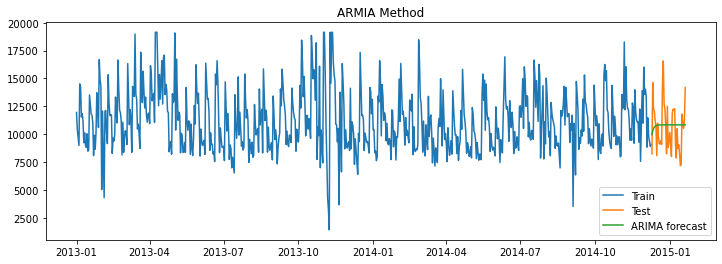

In [1920]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[5]['Sales'][:-42], label='Train')
plt.plot(store_new_df[5]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1921]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_25_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56

### VAR

In [1922]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  708
Model:                             VAR(1)   Log Likelihood                1090.620
Date:                    Mon, 16 Aug 2021   AIC                          -2167.240
Time:                            22:26:39   BIC                          -2135.303
Sample:                        01-01-2013   HQIC                         -2154.901
                             - 12-09-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            92.44, 0.82   Jarque-Bera (JB):      2757.34, 153.57
Prob(Q):                        0.00, 0.37   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.85, 1.34   Skew:                      1.17, -0.44
Prob(H) (two-sided):            0.23, 0.03   Kurtosis:                  12.38, 5.10


In [1923]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

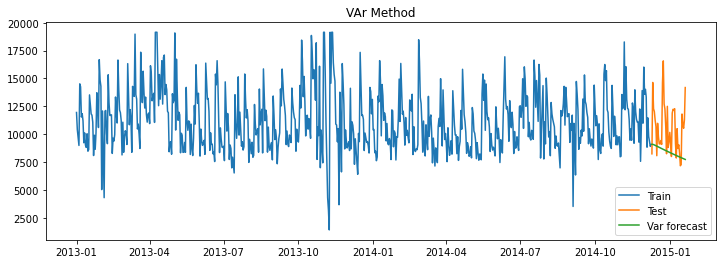

In [1924]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[5]['Sales'][:-42], label='Train')
plt.plot(store_new_df[5]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1925]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_25_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54

### Johansen cointegration Test

In [1926]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1927]:
### No Conintegration hence both sales and Customers are stationary

In [1928]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  708
Model:                            VARX(2)   Log Likelihood                1241.632
                              + intercept   AIC                          -2453.264
Date:                    Mon, 16 Aug 2021   BIC                          -2384.828
Time:                            22:26:49   HQIC                         -2426.824
Sample:                        01-01-2013                                         
                             - 12-09-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.34, 0.18   Jarque-Bera (JB):      1199.40, 140.45
Prob(Q):                        0.56, 0.67   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.80, 1.33   Skew:                     -0.69, -0.49
P

In [1929]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


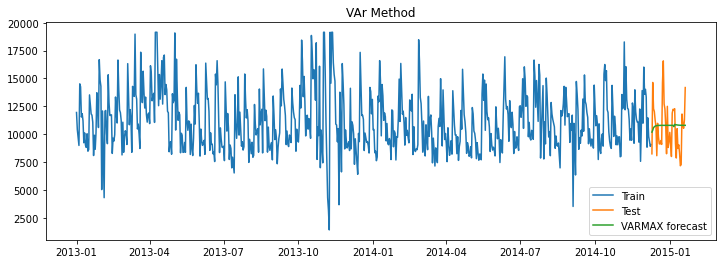

In [1930]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[5]['Sales'][:-42], label='Train')
plt.plot(store_new_df[5]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1931]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_25_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67

In [1932]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  708
Model:                            VARX(2)   Log Likelihood                1331.237
                              + intercept   AIC                          -2632.474
Date:                    Mon, 16 Aug 2021   BIC                          -2564.037
Time:                            22:26:57   HQIC                         -2606.033
Sample:                        01-01-2013                                         
                             - 12-09-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.83, 0.07   Jarque-Bera (JB):      2042.71, 148.74
Prob(Q):                        0.36, 0.79   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.87, 1.43   Skew:                     -0.50, -0.54
P

In [1933]:
## Better AIC value with promo

In [1934]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



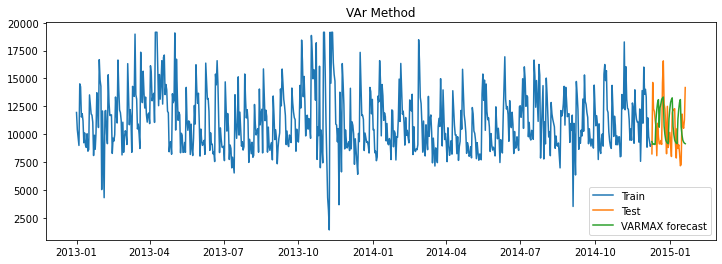

In [1935]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[5]['Sales'][:-42], label='Train')
plt.plot(store_new_df[5]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1936]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_25_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22

<AxesSubplot:>

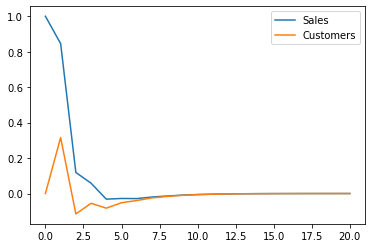

In [1937]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

#### Model Building for store 29

In [1938]:
##Data Preparation

In [1939]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[6])

779

In [1940]:
train = store_new_df[6][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[6][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

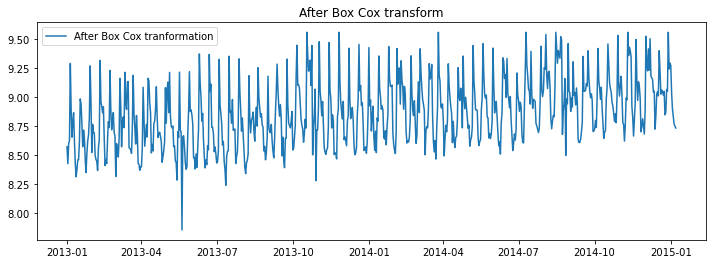

In [1941]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1942]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -3.208758
p-value: 0.019483
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -3.790368
p-value: 0.003007
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -8.092541
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.319335
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.356925
p-value: 0.000004
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


#### Training data is stationary

## Model Building

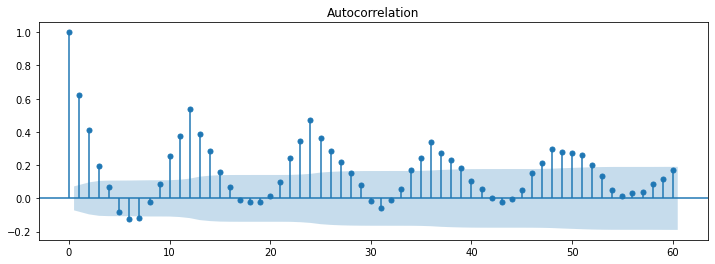

In [1943]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

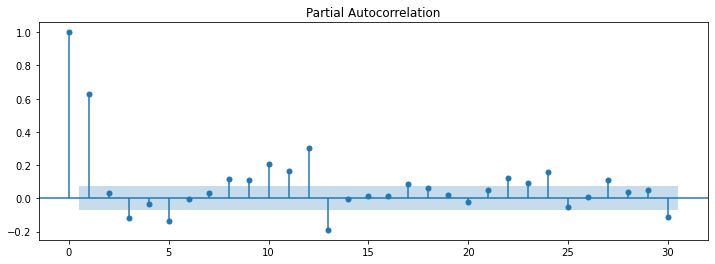

In [1944]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1945]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  737
Model:                     ARMA(1, 1)   Log Likelihood                  74.385
Method:                       css-mle   S.D. of innovations              0.219
Date:                Mon, 16 Aug 2021   AIC                           -140.770
Time:                        22:26:59   BIC                           -122.360
Sample:                    01-01-2013   HQIC                          -133.670
                         - 01-07-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.8557      0.022    402.106      0.000       8.813       8.899
ar.L1.Sales     0.6496      0.041     15.988      0.000       0.570       0.729
ma.L1.Sales    -0.0396      0.050     -0.798    

In [1946]:
y_hat_ar = store_new_df[6]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


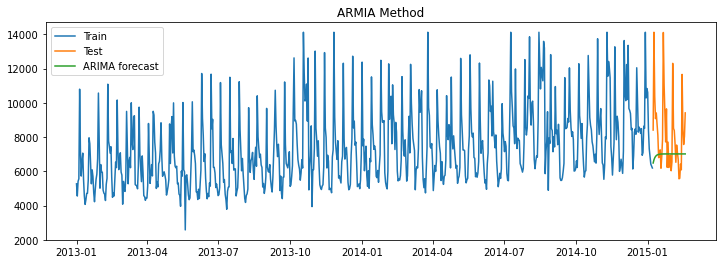

In [1947]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[6]['Sales'][:-42], label='Train')
plt.plot(store_new_df[6]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1948]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_29_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61

### VAR

In [1949]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                             VAR(1)   Log Likelihood                1296.547
Date:                    Mon, 16 Aug 2021   AIC                          -2579.094
Time:                            22:27:00   BIC                          -2546.876
Sample:                        01-01-2013   HQIC                         -2566.670
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            34.65, 0.65   Jarque-Bera (JB):         118.40, 6.76
Prob(Q):                        0.00, 0.42   Prob(JB):                   0.00, 0.03
Heteroskedasticity (H):         0.78, 1.03   Skew:                      0.58, -0.13
Prob(H) (two-sided):            0.05, 0.84   Kurtosis:                   4.59, 3.39


In [1950]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

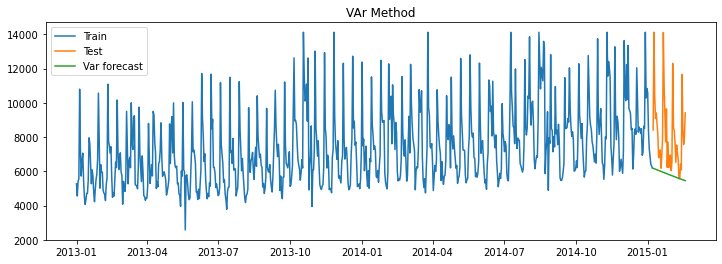

In [1951]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[6]['Sales'][:-42], label='Train')
plt.plot(store_new_df[6]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1952]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_29_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39

### Johansen cointegration Test

In [1953]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1954]:
### No Conintegration hence both sales and Customers are stationary

In [1955]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                            VARX(2)   Log Likelihood                1384.235
                              + intercept   AIC                          -2738.471
Date:                    Mon, 16 Aug 2021   BIC                          -2669.432
Time:                            22:27:04   HQIC                         -2711.847
Sample:                        01-01-2013                                         
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.12, 0.03   Jarque-Bera (JB):        228.21, 11.38
Prob(Q):                        0.72, 0.86   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.80, 1.01   Skew:                      0.96, -0.17
P

In [1956]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


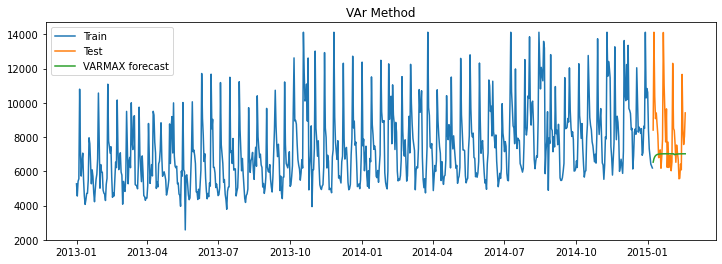

In [1957]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[6]['Sales'][:-42], label='Train')
plt.plot(store_new_df[6]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1958]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_29_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45

In [1959]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  737
Model:                            VARX(2)   Log Likelihood                1445.851
                              + intercept   AIC                          -2861.702
Date:                    Mon, 16 Aug 2021   BIC                          -2792.663
Time:                            22:27:09   HQIC                         -2835.078
Sample:                        01-01-2013                                         
                             - 01-07-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.03, 0.96   Jarque-Bera (JB):         102.62, 9.23
Prob(Q):                        0.87, 0.33   Prob(JB):                   0.00, 0.01
Heteroskedasticity (H):         0.81, 0.99   Skew:                      0.54, -0.17
P

In [1960]:
## Better AIC value with promo

In [1961]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



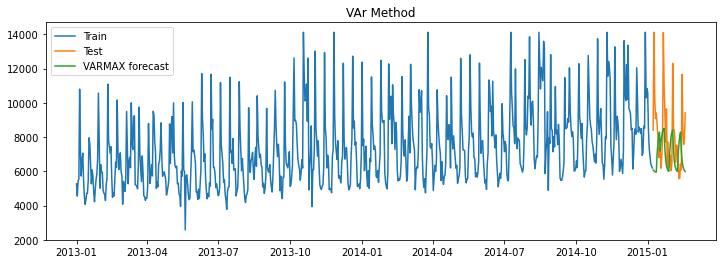

In [1962]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[6]['Sales'][:-42], label='Train')
plt.plot(store_new_df[6]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1963]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_29_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31

<AxesSubplot:>

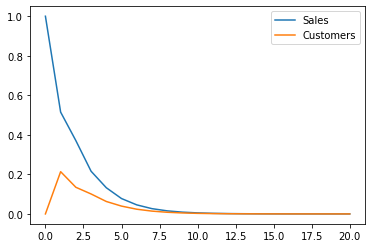

In [1964]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

#### Model Building for store 31

In [1965]:
##Data Preparation

In [1966]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[7])

784

In [1967]:
train = store_new_df[7][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[7][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

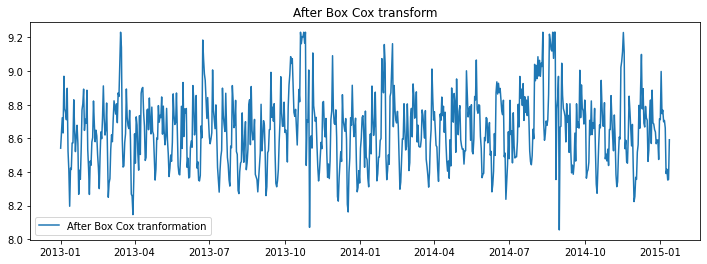

In [1968]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1969]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -5.857095
p-value: 0.000000
Critical Values:
	5%: -2.866


Customers: ADF test results:
ADF Statistic: -6.179924
p-value: 0.000000
Critical Values:
	5%: -2.866


DayOfWeek: ADF test results:
ADF Statistic: -7.126625
p-value: 0.000000
Critical Values:
	5%: -2.866


Promo: ADF test results:
ADF Statistic: -6.469992
p-value: 0.000000
Critical Values:
	5%: -2.866


SchoolHoliday: ADF test results:
ADF Statistic: -5.813130
p-value: 0.000000
Critical Values:
	5%: -2.866


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.865


#### Training data is stationary

## Model Building

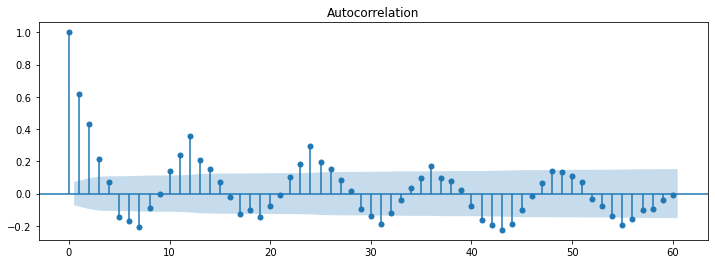

In [1970]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

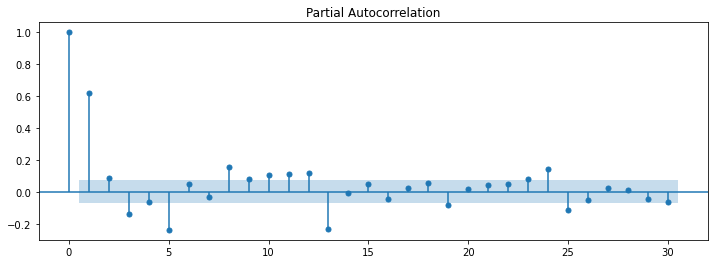

In [1971]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1972]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  742
Model:                     ARMA(1, 1)   Log Likelihood                 276.154
Method:                       css-mle   S.D. of innovations              0.167
Date:                Mon, 16 Aug 2021   AIC                           -544.308
Time:                        22:27:11   BIC                           -525.870
Sample:                    01-01-2013   HQIC                          -537.200
                         - 01-12-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.6511      0.017    507.856      0.000       8.618       8.684
ar.L1.Sales     0.6751      0.039     17.502      0.000       0.599       0.751
ma.L1.Sales    -0.0933      0.047     -1.966    

In [1973]:
y_hat_ar = store_new_df[7]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


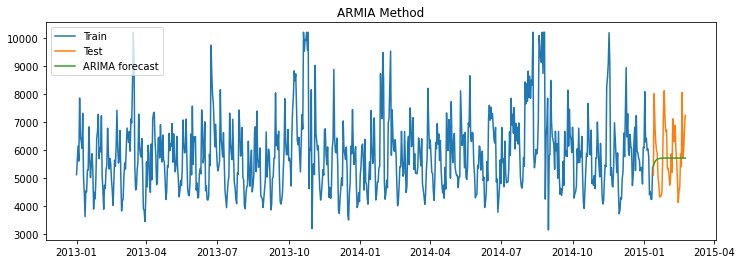

In [1974]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[7]['Sales'][:-42], label='Train')
plt.plot(store_new_df[7]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [1975]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_31_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03

### VAR

In [1976]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                             VAR(1)   Log Likelihood                1301.434
Date:                    Mon, 16 Aug 2021   AIC                          -2588.868
Time:                            22:27:12   BIC                          -2556.602
Sample:                        01-01-2013   HQIC                         -2576.429
                             - 01-12-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            49.64, 0.29   Jarque-Bera (JB):       267.04, 435.28
Prob(Q):                        0.00, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.22, 0.96   Skew:                      -0.41, 0.23
Prob(H) (two-sided):            0.12, 0.73   Kurtosis:                   5.82, 6.72


In [1977]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

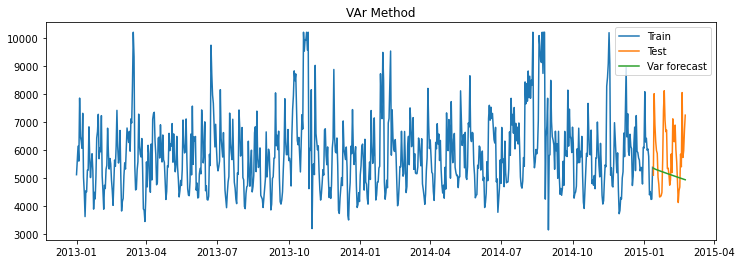

In [1978]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[7]['Sales'][:-42], label='Train')
plt.plot(store_new_df[7]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1979]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_31_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25

### Johansen cointegration Test

In [1980]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [1981]:
### No Conintegration hence both sales and Customers are stationary

In [1982]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                            VARX(2)   Log Likelihood                1414.364
                              + intercept   AIC                          -2798.729
Date:                    Mon, 16 Aug 2021   BIC                          -2729.588
Time:                            22:27:19   HQIC                         -2772.074
Sample:                        01-01-2013                                         
                             - 01-12-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.04, 0.00   Jarque-Bera (JB):       47.28, 1033.49
Prob(Q):                        0.84, 0.98   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.16, 0.98   Skew:                       0.09, 0.71
P

In [1983]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


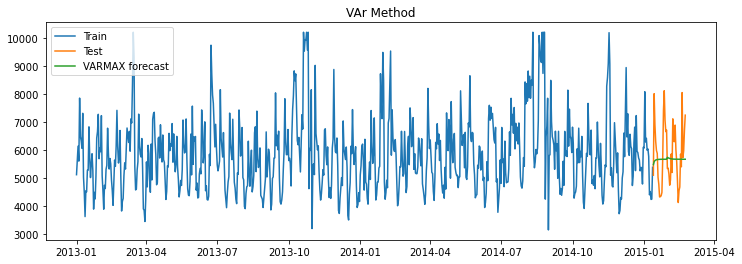

In [1984]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[7]['Sales'][:-42], label='Train')
plt.plot(store_new_df[7]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1985]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_31_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25
0  Store_31_VARMAX_SchoolHoliday  15.42  1098.50

In [1986]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  742
Model:                            VARX(2)   Log Likelihood                1534.102
                              + intercept   AIC                          -3038.204
Date:                    Mon, 16 Aug 2021   BIC                          -2969.064
Time:                            22:27:25   HQIC                         -3011.550
Sample:                        01-01-2013                                         
                             - 01-12-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.22, 4.57   Jarque-Bera (JB):        34.73, 854.42
Prob(Q):                        0.64, 0.03   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.23, 0.99   Skew:                       0.08, 0.59
P

In [1987]:
## Better AIC value with promo

In [1988]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



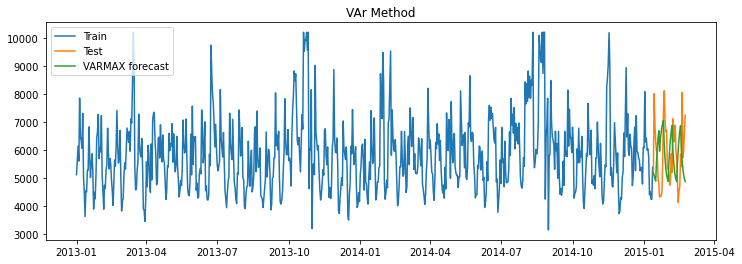

In [1989]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[7]['Sales'][:-42], label='Train')
plt.plot(store_new_df[7]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [1990]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_31_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25
0  Store_31_VARMAX_SchoolHoliday  15.42  1098.50
0                 Store_31_Promo  23.28  1489.03

<AxesSubplot:>

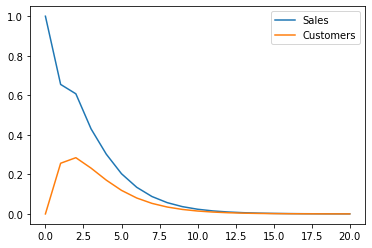

In [1991]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

#### Model Building for store 45

In [1992]:
##Data Preparation

In [1993]:
# first two and half years as training set
# last six weeks as test set (means 42 days)
len(store_new_df[8])

622

In [1994]:
train = store_new_df[8][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][:-42]
test = store_new_df[8][['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']][-42:]

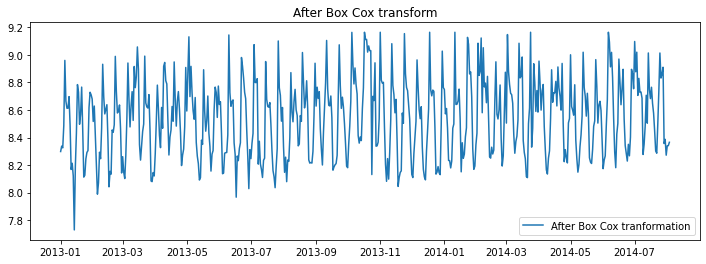

In [1995]:
##Standardizing train_data
from scipy.stats import boxcox
train_boxcox = pd.DataFrame(boxcox(train['Sales'], lmbda=0), index = train.index, columns=['Sales'])
train_boxcox['Customers'] =  pd.Series(boxcox(train['Customers'], lmbda=0), index = train.index)

# plotting Sales after boxcox transformation
plt.figure(figsize=(12,4))
plt.plot(train_boxcox['Sales'], label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

In [1996]:
ls = ['Sales','Customers','DayOfWeek','Promo','SchoolHoliday','StateHoliday']
for i in range(len(ls)):
    print('\n\n' + ls[i] + ': ADF test results:')
    result = adfuller(train[ls[i]].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        if key=='5%':
            print('\t%s: %.3f' % (key, value))



Sales: ADF test results:
ADF Statistic: -5.200115
p-value: 0.000009
Critical Values:
	5%: -2.867


Customers: ADF test results:
ADF Statistic: -5.417107
p-value: 0.000003
Critical Values:
	5%: -2.867


DayOfWeek: ADF test results:
ADF Statistic: -7.185178
p-value: 0.000000
Critical Values:
	5%: -2.867


Promo: ADF test results:
ADF Statistic: -6.289072
p-value: 0.000000
Critical Values:
	5%: -2.867


SchoolHoliday: ADF test results:
ADF Statistic: -7.417247
p-value: 0.000000
Critical Values:
	5%: -2.867


StateHoliday: ADF test results:
ADF Statistic: nan
p-value: nan
Critical Values:
	5%: -2.867


#### Training data is stationary

## Model Building

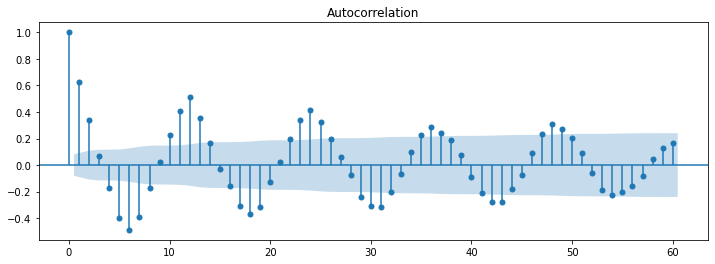

In [1997]:
#ACF
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox['Sales'], ax=plt.gca(), lags = 60)
plt.show()

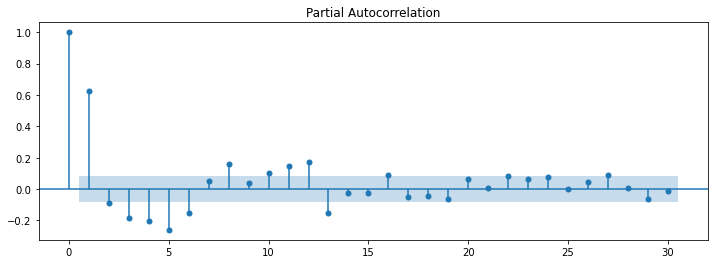

In [1998]:
#PCF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox['Sales'], ax=plt.gca(), lags = 30)
plt.show()


### Arima Model

In [1999]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_boxcox['Sales'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  580
Model:                     ARMA(1, 1)   Log Likelihood                  62.804
Method:                       css-mle   S.D. of innovations              0.217
Date:                Mon, 16 Aug 2021   AIC                           -117.608
Time:                        22:27:27   BIC                           -100.156
Sample:                    01-01-2013   HQIC                          -110.804
                         - 08-03-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.5417      0.023    371.595      0.000       8.497       8.587
ar.L1.Sales     0.5738      0.048     11.831      0.000       0.479       0.669
ma.L1.Sales     0.0898      0.054      1.655    

In [2000]:
y_hat_ar = store_new_df[8]['Sales'].copy()
y_hat_ar['ar_forecast_boxcox'] = model_fit.predict(start = test.index.min(), end = test.index.max())
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])


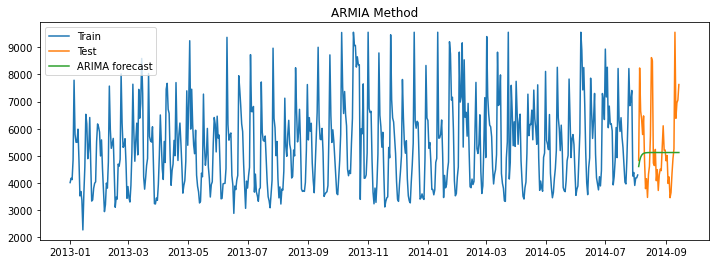

In [2001]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[8]['Sales'][:-42], label='Train')
plt.plot(store_new_df[8]['Sales'][-42:], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARMIA Method')
plt.show()

In [2002]:


rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_ar['ar_forecast'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_46_ARIMA '], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25
0  Store_31_VARMAX_SchoolHoliday  15.42  1098.50
0                 Store_31_Promo  23.28  1489.03
0                Store_46_ARIMA   20.28  1527.52

### VAR

In [2003]:
mod = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']], order=(1,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  580
Model:                             VAR(1)   Log Likelihood                 902.196
Date:                    Mon, 16 Aug 2021   AIC                          -1790.391
Time:                            22:27:28   BIC                          -1759.850
Sample:                        01-01-2013   HQIC                         -1778.484
                             - 08-03-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.23, 1.23   Jarque-Bera (JB):          40.89, 0.38
Prob(Q):                        0.63, 0.27   Prob(JB):                   0.00, 0.83
Heteroskedasticity (H):         1.18, 1.18   Skew:                      0.00, -0.05
Prob(H) (two-sided):            0.24, 0.25   Kurtosis:                   4.30, 3.07


In [2004]:
# forecast
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_var = mod.fit().predict(start=start_index, end=end_index)
y_hat_var = np.exp(y_hat_var)

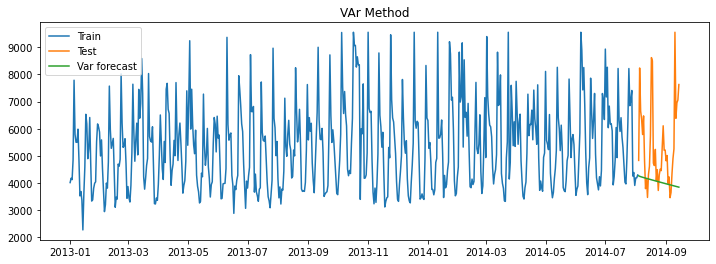

In [2005]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[8]['Sales'][:-42], label='Train')
plt.plot(store_new_df[8]['Sales'][-42:], label='Test')
plt.plot(y_hat_var['Sales'][test.index.min():], label='Var forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [2006]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_var['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_var['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_31_VAR'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25
0  Store_31_VARMAX_SchoolHoliday  15.42  1098.50
0                 Store_31_Promo  23.28  1489.03
0                Store_46_ARIMA   20.28  1527.52
0                   Store_31_VAR  22.43  1996.58

### Johansen cointegration Test

In [2007]:
coint=coint_johansen(np.asarray(train_boxcox[['Sales','Customers']]),0,1)
# coint.trace_stat
# coint.max_eig_stat
traces = coint.lr1
maxeig=coint.lr2
cvts = coint.cvt  ## 0: 90%  1:95% 2: 99%
cvms = coint.cvm   ## 0: 90%  1:95% 2: 99%

N, l = np.asarray(train[['Sales','Customers']]).shape

for i in range(l):
    if traces[i] > cvts[i, 1]:
        r = i + 1
print(r)

2


In [2008]:
### No Conintegration hence both sales and Customers are stationary

In [2009]:
exog = train['SchoolHoliday']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  580
Model:                            VARX(2)   Log Likelihood                1001.092
                              + intercept   AIC                          -1972.183
Date:                    Mon, 16 Aug 2021   BIC                          -1906.738
Time:                            22:27:34   HQIC                         -1946.668
Sample:                        01-01-2013                                         
                             - 08-03-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.42, 0.01   Jarque-Bera (JB):         69.34, 19.52
Prob(Q):                        0.51, 0.91   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.11, 1.24   Skew:                       0.65, 0.38
P

In [2010]:

start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)


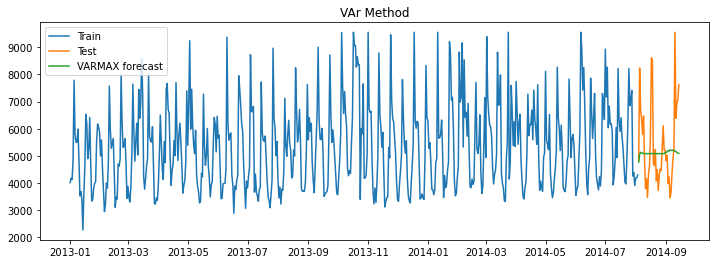

In [2011]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[8]['Sales'][:-42], label='Train')
plt.plot(store_new_df[8]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [2012]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_45_VARMAX_SchoolHoliday'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25
0  Store_31_VARMAX_SchoolHoliday  15.42  1098.50
0                 Store_31_Promo  23.28  1489.03
0                Store_46_ARIMA   20.28  1527.52
0                   Store_31_VAR  22.43  1996.58
0  Store_45_VARMAX_SchoolHoliday  20.08  1511.66

In [2013]:
exog = train['Promo']
mod_varmax = sm.tsa.VARMAX(train_boxcox[['Sales', 'Customers']],exog= exog, order=(2,0), trend='c')
resmax = mod_varmax.fit(maxiter=1000, disp=False)
print(resmax.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  580
Model:                            VARX(2)   Log Likelihood                1199.300
                              + intercept   AIC                          -2368.600
Date:                    Mon, 16 Aug 2021   BIC                          -2303.154
Time:                            22:27:39   HQIC                         -2343.085
Sample:                        01-01-2013                                         
                             - 08-03-2014                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             3.52, 7.71   Jarque-Bera (JB):          22.72, 6.82
Prob(Q):                        0.06, 0.01   Prob(JB):                   0.00, 0.03
Heteroskedasticity (H):         1.02, 1.51   Skew:                       0.36, 0.22
P

In [2014]:
## Better AIC value with promo

In [2015]:
start_index = test['Sales'].index.min()
end_index = test['Sales'].index.max()
y_hat_varmax = resmax.predict(start=start_index, end=end_index,exog = np.array(exog[-42:]).reshape(42,1))
y_hat_varmax = np.exp(y_hat_varmax)



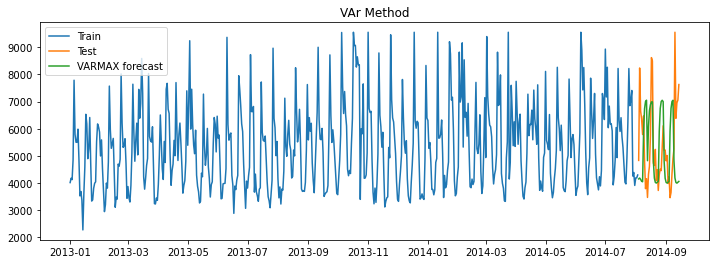

In [2016]:
plt.figure(figsize=(12,4))
plt.plot(store_new_df[8]['Sales'][:-42], label='Train')
plt.plot(store_new_df[8]['Sales'][-42:], label='Test')
plt.plot(y_hat_varmax['Sales'][test.index.min():], label='VARMAX forecast')
plt.legend(loc='best')
plt.title('VAr Method')
plt.show()

In [2017]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'])).round(2)
#print('Income: RMSE:',  rmse)

rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_varmax['Sales'][test.index.min():])).round(2)
mape = np.round(np.mean(np.abs(test['Sales']-y_hat_varmax['Sales'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Store_45_Promo'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results

Method   MAPE     RMSE
0                 Store_1_ARIMA   15.48   756.47
0                    Store_1_VAR  20.94  1227.40
0   Store_1_VARMAX_SchoolHoliday  15.56   760.01
0                  Store_1_Promo  20.04   982.31
0                 Store_3_ARIMA   18.22  1674.18
0                    Store_3_VAR  24.86  2402.26
0   Store_3_VARMAX_SchoolHoliday  23.68  2028.11
0                  Store_3_Promo  37.30  2773.17
0                 Store_8_ARIMA   21.08  1634.73
0                    Store_8_VAR  32.55  2861.01
0   Store_8_VARMAX_SchoolHoliday  27.78  2448.17
0                  Store_8_Promo  37.01  2903.56
0                 Store_9_ARIMA   17.06  1985.39
0                    Store_9_VAR  17.64  2087.96
0   Store_9_VARMAX_SchoolHoliday  17.10  1991.61
0                  Store_9_Promo  20.15  2082.44
0                Store_13_ARIMA   29.89  1921.82
0                   Store_13_VAR  32.24  2657.13
0  Store_13_VARMAX_SchoolHoliday  29.45  1894.80
0                 Store_13_Promo  42.67  2583.78
0                Store_25_ARIMA   17.77  2168.56
0                   Store_25_VAR  19.52  3004.54
0  Store_25_VARMAX_SchoolHoliday  17.73  2166.67
0                 Store_25_Promo  25.32  2892.22
0                Store_29_ARIMA   17.24  2396.61
0                   Store_29_VAR  24.99  3079.39
0  Store_29_VARMAX_SchoolHoliday  17.19  2384.45
0                 Store_29_Promo  22.74  2568.31
0                Store_31_ARIMA   15.45  1098.03
0                   Store_31_VAR  16.24  1296.25
0  Store_31_VARMAX_SchoolHoliday  15.42  1098.50
0                 Store_31_Promo  23.28  1489.03
0                Store_46_ARIMA   20.28  1527.52
0                   Store_31_VAR  22.43  1996.58
0  Store_45_VARMAX_SchoolHoliday  20.08  1511.66
0                 Store_45_Promo  32.45  2099.25

<AxesSubplot:>

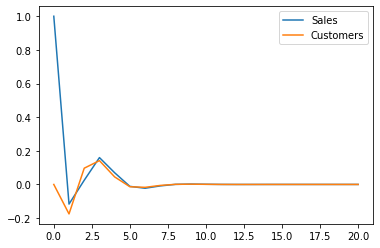

In [2018]:
irf = resmax.impulse_responses(steps = 20, orthogonalized= False)
irf.plot()

Conclusion:

The MAPE and RMSE value has been evaluated MAPE value for different model of each stores.It is observed that VARMAX model has perfromed well compared to ARIMA and VAR.ARIMA is the next best model The exogenous variable test were 'PROMO and  SchoolHoliday'. VARMAX with exogenous varible schoolholiday has perfomed well.
